In [1]:
import os
import sys
from tqdm import tqdm
from datetime import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch

In [2]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

train_file = np.load("./cse-251-b-2025/train.npz")
train_data = train_file['data']
print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)

test_file = np.load("./cse-251-b-2025/test_input.npz")
test_data = test_file['data']
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

In [3]:
# Run visualizations?
run_visualizations: bool = False

# From data loading notebook
def plot_one_training_scene(idx: int = 0):
    # Plot trajectories from one training scene (static plot)
    data_matrix = train_data[idx]

    plt.figure(figsize=(8, 8))
    for agent in range(data_matrix.shape[idx]):
        xs = data_matrix[agent, :, 0]
        ys = data_matrix[agent, :, 1]
        # Remove zeros (padding)
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.7)
    plt.title("Trajectories from one training scene")
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")
    plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

if run_visualizations:
    plot_one_training_scene(0)
    make_gif(train_data[0], 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [4]:
# Run constant velocity model (Kaggle score of ~50)?
run_constant_velocity_model: bool = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [5]:
# MLP model with residual blocks: ineffective for TimeSeries data
class BasicMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # Lazy layers infer the input size instead of having to explicitly pass it in
        # Backbone: linear -> BatchNorm -> PReLU -> Dropout
        self.net = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
        ) # Note: residual width must match the last width of the net

        # Residual block added to avoid vanishing gradient issue
        self.residual = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(256),
        )

        # Infer last input shape, then do final projection (60*2)
        self.head = nn.LazyLinear(output_features)

    def forward(self, x):
        # Original forward loop
        # # (batch, 50, 50, 6) or flattened already
        # x = x.view(x.size(0), -1)
        # h = self.net(x) #(batch, 256)
        # h = h + self.residual(h)  # residual skip
        # return self.head(h) #(batch, 120)

        # Taken from milestone notebook (tensor format)
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.net(x)
        x = x + self.residual(x)
        x = self.head(x)
        return x.view(-1, 60, 2)

In [6]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(BaseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [7]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        # x = data.x
        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        # x = x.reshape(-1, 50 * 50 * 6)
        # x = self.mlp(x)
        # return x.view(-1, 60, 2)
        # In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)

        out = self.decoder(combined) #(B, 120)
        return out.view(-1, 60, 2)

In [8]:
# Extended from the base LSTM model
class LSTMWithMLP(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(LSTMWithMLP, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        x = self.net(lstm_out[:, -1, :])
        x = self.fc(x)
        return x.view(-1, 60, 2)

# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [10]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [11]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model_instance, path="our_model.pth"):
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(trained_model)
# model = load_model()

In [12]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%I-%M%p")

In [13]:
# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features:int = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features:int = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size: int = 64
num_folds: int = 4
early_stopping_patience: int = 30
early_stopping_threshold: float = 1e-4
epochs: int = 250
starting_lr: float = 1e-2
scale: float = 7.0
weight_decay: float = 1e-2

lstm_hidden_dim: int = 256

# IMPORTANT! To change which model is used: comment/uncomment below
# Easily swap models by changing what is returned (called in training and test to avoid conflicts)
def get_model():
    # return BasicMLP(input_features, output_features).to(device)
    # return BaseLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return SceneContextModel(hidden_dim=864).to(device)
    return LSTMWithMLP(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)

SEED: int = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

def train_model(full_training_data: np.ndarray, 
                batch_size:int = 64, epochs:int = 10, num_folds:int = 5,
                early_stopping_patience:int = 5, early_stopping_threshold:float = 1e-3):
    global starting_lr, gamma, scale, lstm_hidden_dim, output_features, weight_decay

    # Time series data needs to keep its data in relative order, so no shuffling can occur
    #   like in regular KFold cross validation
    splitter = TimeSeriesSplit(n_splits=num_folds)

    # Perform cross-validation, the best model will be saved as "best_model.pt" to be loaded in later
    overall_best_val_loss = float("inf")

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    # https://www.geeksforgeeks.org/time-series-cross-validation/
    for fold_i, (train_idx, val_idx) in enumerate(splitter.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # If you change the model here, ensure its the same in the test loop!
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()

        model = get_model()
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=weight_decay)
        schedulers: list[lr_scheduler.LRScheduler] =[
            lr_scheduler.ExponentialLR(optimizer, gamma=0.995),
            lr_scheduler.MultiStepLR(
                optimizer,
                milestones= list(range(25, epochs, 25)),
                gamma=0.75,
            ),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(100, epochs, 100)),
            #     gamma=0.5,
            # ),
            lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max= int(epochs * 0.9),
                eta_min=1e-5
            ),
        ]

        # Prepare data from this fold
        train_fold: np.ndarray = full_training_data[train_idx]
        val_fold: np.ndarray = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if not isinstance(model, SceneContextModel):
            # LSTM can handle the timeseries data directly
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
        else:
            train_x: np.ndarray = train_fold[..., :50, :]
            train_y: np.ndarray = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x: np.ndarray = val_fold[..., :50, :]
            val_y: np.ndarray = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        best_val_loss: float = float("inf")
        no_improvement: int = 0

        # Training and validation loops are taken from the milestone notebook,
        #   with modifications to allow for different data loading shapes      
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            # Training loop
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                        batch_y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = batch_y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)

            if (epoch + 1) % 5 == 0:
                tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    overall_best_val_loss = best_val_loss
                    torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print(f"==== EARLY STOP at epoch {(epoch + 1):03d}")
                    break

            for sched in schedulers:
                sched.step()


# Load in the model saved during testing to use on X_test
# Mostly taken from milestone notebook
def predict(X_test: np.ndarray, best_model_path: str = "best_model.pt"):
    global scale, batch_size, lstm_hidden_dim, output_features

    # Ensure this aligns with the trained model!
    best_model = torch.load(best_model_path)
    model = get_model()
    model.load_state_dict(best_model)
    model.eval()

    pred_list = []
    with torch.no_grad():
        if not isinstance(model, SceneContextModel): # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)

                # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())
        else:
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

# Train the model (tweak batch_size and epochs as needed at top of this block)
# Saved as "best_model.pt" to be loaded in during testing
train_model(train_data, batch_size=batch_size, epochs=epochs, num_folds=num_folds,
            early_stopping_patience=early_stopping_patience,
            early_stopping_threshold=early_stopping_threshold)

# Make predictions on the test set
model_predictions_df = predict(test_data)
assert len(model_predictions_df) == 126000, f"Incorrect number of rows in output, expected 126000, got {len(model_predictions_df)}"

# Save output in the submission foldder, timestamped!
submission_path = os.path.join(submission_dir, f"submission-{get_timestamp()}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")


FOLD 1/4 ==================================


Epoch:   2%|▏         | 5/250 [00:15<12:17,  3.01s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   0.5750 | val normalized MSE   0.3920, | val MAE   2.3824 | val MSE  19.2069


Epoch:   4%|▍         | 10/250 [00:29<11:29,  2.87s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   0.5584 | val normalized MSE   0.4404, | val MAE   2.6983 | val MSE  21.5797


Epoch:   6%|▌         | 15/250 [00:43<11:13,  2.86s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   0.5273 | val normalized MSE   0.4179, | val MAE   2.5615 | val MSE  20.4755


Epoch:   8%|▊         | 20/250 [00:58<11:17,  2.94s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   0.4303 | val normalized MSE   0.4475, | val MAE   2.7078 | val MSE  21.9292


Epoch:  10%|█         | 25/250 [01:13<11:04,  2.95s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   0.3606 | val normalized MSE   0.2685, | val MAE   1.9951 | val MSE  13.1560


Epoch:  12%|█▏        | 30/250 [01:27<10:41,  2.92s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   0.3487 | val normalized MSE   0.2219, | val MAE   1.6534 | val MSE  10.8737


Epoch:  14%|█▍        | 35/250 [01:42<10:32,  2.94s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   0.3192 | val normalized MSE   0.2454, | val MAE   1.9116 | val MSE  12.0266


Epoch:  16%|█▌        | 40/250 [01:56<10:00,  2.86s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   0.3487 | val normalized MSE   0.2338, | val MAE   1.6874 | val MSE  11.4570


Epoch:  18%|█▊        | 45/250 [02:11<09:50,  2.88s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   0.3251 | val normalized MSE   0.2704, | val MAE   2.0272 | val MSE  13.2503


Epoch:  20%|██        | 50/250 [02:25<09:36,  2.88s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   0.3058 | val normalized MSE   0.2344, | val MAE   1.8030 | val MSE  11.4864


Epoch:  22%|██▏       | 55/250 [02:39<09:12,  2.83s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   0.2899 | val normalized MSE   0.2172, | val MAE   1.6382 | val MSE  10.6421


Epoch:  24%|██▍       | 60/250 [02:53<08:58,  2.84s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   0.2824 | val normalized MSE   0.2225, | val MAE   1.7484 | val MSE  10.9049


Epoch:  26%|██▌       | 65/250 [03:08<08:52,  2.88s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   0.2646 | val normalized MSE   0.1992, | val MAE   1.5665 | val MSE   9.7617


Epoch:  28%|██▊       | 70/250 [03:22<08:42,  2.90s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   0.2929 | val normalized MSE   0.2226, | val MAE   1.6888 | val MSE  10.9082


Epoch:  30%|███       | 75/250 [03:37<08:28,  2.90s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   0.2768 | val normalized MSE   0.2156, | val MAE   1.6559 | val MSE  10.5640


Epoch:  32%|███▏      | 80/250 [03:51<08:08,  2.87s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   0.2520 | val normalized MSE   0.2107, | val MAE   1.5912 | val MSE  10.3249


Epoch:  34%|███▍      | 85/250 [04:05<07:51,  2.86s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   0.2637 | val normalized MSE   0.2119, | val MAE   1.6176 | val MSE  10.3852


Epoch:  36%|███▌      | 90/250 [04:20<07:41,  2.88s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   0.2407 | val normalized MSE   0.2032, | val MAE   1.5667 | val MSE   9.9561


Epoch:  38%|███▊      | 95/250 [04:34<07:22,  2.85s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   0.2582 | val normalized MSE   0.2030, | val MAE   1.5746 | val MSE   9.9491


Epoch:  40%|████      | 100/250 [04:48<07:05,  2.83s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   0.2209 | val normalized MSE   0.1969, | val MAE   1.5414 | val MSE   9.6496


Epoch:  42%|████▏     | 105/250 [05:02<06:54,  2.86s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   0.2161 | val normalized MSE   0.1948, | val MAE   1.4762 | val MSE   9.5461


Epoch:  44%|████▍     | 110/250 [05:17<06:43,  2.88s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   0.2741 | val normalized MSE   0.2032, | val MAE   1.5593 | val MSE   9.9561


Epoch:  46%|████▌     | 115/250 [05:31<06:28,  2.88s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   0.2297 | val normalized MSE   0.2122, | val MAE   1.6084 | val MSE  10.4001


Epoch:  48%|████▊     | 120/250 [05:45<06:11,  2.86s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   0.2443 | val normalized MSE   0.1890, | val MAE   1.4586 | val MSE   9.2634


Epoch:  50%|█████     | 125/250 [06:00<05:53,  2.83s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE   0.2300 | val normalized MSE   0.1928, | val MAE   1.5047 | val MSE   9.4460


Epoch:  52%|█████▏    | 130/250 [06:14<05:46,  2.89s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE   0.2243 | val normalized MSE   0.1909, | val MAE   1.4930 | val MSE   9.3558


Epoch:  54%|█████▍    | 135/250 [06:29<05:34,  2.91s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE   0.2329 | val normalized MSE   0.1846, | val MAE   1.4240 | val MSE   9.0467


Epoch:  56%|█████▌    | 140/250 [06:43<05:15,  2.87s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE   0.2209 | val normalized MSE   0.1916, | val MAE   1.4902 | val MSE   9.3901


Epoch:  58%|█████▊    | 145/250 [06:57<05:00,  2.86s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE   0.2162 | val normalized MSE   0.1970, | val MAE   1.5457 | val MSE   9.6552


Epoch:  60%|██████    | 150/250 [07:11<04:46,  2.86s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE   0.2100 | val normalized MSE   0.1911, | val MAE   1.4708 | val MSE   9.3655


Epoch:  62%|██████▏   | 155/250 [07:26<04:39,  2.94s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE   0.2127 | val normalized MSE   0.1986, | val MAE   1.5247 | val MSE   9.7304


Epoch:  64%|██████▍   | 160/250 [07:41<04:21,  2.91s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE   0.2044 | val normalized MSE   0.1839, | val MAE   1.3947 | val MSE   9.0087


Epoch:  66%|██████▌   | 165/250 [07:55<04:05,  2.89s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE   0.2333 | val normalized MSE   0.1963, | val MAE   1.5158 | val MSE   9.6171


Epoch:  68%|██████▊   | 170/250 [08:10<03:51,  2.89s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE   0.2228 | val normalized MSE   0.1939, | val MAE   1.4956 | val MSE   9.5023


Epoch:  70%|███████   | 175/250 [08:24<03:36,  2.89s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE   0.2148 | val normalized MSE   0.1921, | val MAE   1.4815 | val MSE   9.4134


Epoch:  72%|███████▏  | 180/250 [08:39<03:21,  2.87s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE   0.2210 | val normalized MSE   0.1988, | val MAE   1.5252 | val MSE   9.7420


Epoch:  74%|███████▍  | 185/250 [08:53<03:06,  2.86s/epoch]

Epoch 185 | Learning rate 0.000049 | train normalized MSE   0.2249 | val normalized MSE   0.1889, | val MAE   1.4518 | val MSE   9.2556


Epoch:  76%|███████▌  | 189/250 [09:07<02:56,  2.90s/epoch]


Epoch 190 | Learning rate 0.000039 | train normalized MSE   0.2051 | val normalized MSE   0.1889, | val MAE   1.4745 | val MSE   9.2572
==== EARLY STOP at epoch 190

FOLD 2/4 ==================================


Epoch:   2%|▏         | 5/250 [00:24<20:15,  4.96s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   0.5633 | val normalized MSE   0.5297, | val MAE   2.8463 | val MSE  25.9575


Epoch:   4%|▍         | 10/250 [00:49<19:49,  4.96s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   0.4206 | val normalized MSE   0.3367, | val MAE   2.2328 | val MSE  16.4974


Epoch:   6%|▌         | 15/250 [01:13<19:06,  4.88s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   0.3334 | val normalized MSE   0.2379, | val MAE   1.7454 | val MSE  11.6585


Epoch:   8%|▊         | 20/250 [01:38<18:35,  4.85s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   0.3304 | val normalized MSE   0.2576, | val MAE   1.8860 | val MSE  12.6207


Epoch:  10%|█         | 25/250 [02:02<18:08,  4.84s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   0.3179 | val normalized MSE   0.2286, | val MAE   1.7159 | val MSE  11.2030


Epoch:  12%|█▏        | 30/250 [02:26<17:49,  4.86s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   0.3023 | val normalized MSE   0.2247, | val MAE   1.6528 | val MSE  11.0093


Epoch:  14%|█▍        | 35/250 [02:51<17:36,  4.92s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   0.3252 | val normalized MSE   0.2427, | val MAE   1.7832 | val MSE  11.8936


Epoch:  16%|█▌        | 40/250 [03:15<17:14,  4.93s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   0.2648 | val normalized MSE   0.2122, | val MAE   1.6111 | val MSE  10.4000


Epoch:  18%|█▊        | 45/250 [03:39<16:36,  4.86s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   0.2786 | val normalized MSE   0.2121, | val MAE   1.6349 | val MSE  10.3941


Epoch:  20%|██        | 50/250 [04:04<16:08,  4.84s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   0.2759 | val normalized MSE   0.2990, | val MAE   2.0832 | val MSE  14.6494


Epoch:  22%|██▏       | 55/250 [04:28<16:06,  4.95s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   0.2591 | val normalized MSE   0.2230, | val MAE   1.7218 | val MSE  10.9282


Epoch:  24%|██▍       | 60/250 [04:53<15:37,  4.94s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   0.2518 | val normalized MSE   0.2126, | val MAE   1.6030 | val MSE  10.4155


Epoch:  26%|██▌       | 65/250 [05:18<15:17,  4.96s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   0.2538 | val normalized MSE   0.2090, | val MAE   1.6228 | val MSE  10.2412


Epoch:  28%|██▊       | 70/250 [05:42<14:42,  4.90s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   0.2428 | val normalized MSE   0.2104, | val MAE   1.5921 | val MSE  10.3082


Epoch:  30%|███       | 75/250 [06:07<14:15,  4.89s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   0.2302 | val normalized MSE   0.2079, | val MAE   1.5628 | val MSE  10.1889


Epoch:  32%|███▏      | 80/250 [06:32<13:58,  4.93s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   0.2298 | val normalized MSE   0.1985, | val MAE   1.5048 | val MSE   9.7263


Epoch:  34%|███▍      | 85/250 [06:56<13:25,  4.88s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   0.2201 | val normalized MSE   0.2186, | val MAE   1.6526 | val MSE  10.7098


Epoch:  36%|███▌      | 90/250 [07:20<13:04,  4.90s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   0.2087 | val normalized MSE   0.2072, | val MAE   1.5422 | val MSE  10.1515


Epoch:  38%|███▊      | 95/250 [07:45<12:33,  4.86s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   0.2058 | val normalized MSE   0.1988, | val MAE   1.5204 | val MSE   9.7406


Epoch:  40%|████      | 100/250 [08:09<12:03,  4.83s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   0.2041 | val normalized MSE   0.2039, | val MAE   1.5494 | val MSE   9.9933


Epoch:  42%|████▏     | 105/250 [08:34<11:52,  4.91s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   0.1950 | val normalized MSE   0.1939, | val MAE   1.4954 | val MSE   9.5008


Epoch:  44%|████▍     | 110/250 [08:58<11:22,  4.88s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   0.2002 | val normalized MSE   0.2097, | val MAE   1.6036 | val MSE  10.2749


Epoch:  46%|████▌     | 115/250 [09:22<11:02,  4.91s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   0.1898 | val normalized MSE   0.1973, | val MAE   1.5145 | val MSE   9.6679


Epoch:  48%|████▊     | 120/250 [09:46<10:25,  4.81s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   0.1859 | val normalized MSE   0.2071, | val MAE   1.5930 | val MSE  10.1488


Epoch:  49%|████▉     | 122/250 [10:01<10:31,  4.93s/epoch]

==== EARLY STOP at epoch 123

FOLD 3/4 ==================================



Epoch:   2%|▏         | 5/250 [00:34<28:17,  6.93s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   0.4918 | val normalized MSE   0.3967, | val MAE   2.4258 | val MSE  19.4372


Epoch:   4%|▍         | 10/250 [01:08<27:29,  6.87s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   0.4036 | val normalized MSE   0.4048, | val MAE   2.4688 | val MSE  19.8346


Epoch:   6%|▌         | 15/250 [01:43<27:01,  6.90s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   0.3675 | val normalized MSE   0.2695, | val MAE   1.9250 | val MSE  13.2059


Epoch:   8%|▊         | 20/250 [02:17<26:20,  6.87s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   0.3337 | val normalized MSE   0.2381, | val MAE   1.7525 | val MSE  11.6693


Epoch:  10%|█         | 25/250 [02:52<25:45,  6.87s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   0.2857 | val normalized MSE   0.2516, | val MAE   1.8079 | val MSE  12.3280


Epoch:  12%|█▏        | 30/250 [03:26<25:20,  6.91s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   0.2787 | val normalized MSE   0.2477, | val MAE   1.7863 | val MSE  12.1354


Epoch:  14%|█▍        | 35/250 [04:00<24:26,  6.82s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   0.2836 | val normalized MSE   0.2048, | val MAE   1.5546 | val MSE  10.0343


Epoch:  16%|█▌        | 40/250 [04:35<24:08,  6.90s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   0.2598 | val normalized MSE   0.2248, | val MAE   1.7090 | val MSE  11.0141


Epoch:  18%|█▊        | 45/250 [05:09<23:21,  6.84s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   0.2436 | val normalized MSE   0.2207, | val MAE   1.6995 | val MSE  10.8164


Epoch:  20%|██        | 50/250 [05:43<22:52,  6.86s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   0.2409 | val normalized MSE   0.2172, | val MAE   1.6370 | val MSE  10.6409


Epoch:  22%|██▏       | 55/250 [06:18<22:21,  6.88s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   0.2312 | val normalized MSE   0.1994, | val MAE   1.5320 | val MSE   9.7730


Epoch:  24%|██▍       | 60/250 [06:52<21:41,  6.85s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   0.2172 | val normalized MSE   0.2150, | val MAE   1.6627 | val MSE  10.5360


Epoch:  26%|██▌       | 65/250 [07:26<21:18,  6.91s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   0.2117 | val normalized MSE   0.2045, | val MAE   1.5646 | val MSE  10.0189


Epoch:  28%|██▊       | 70/250 [08:01<20:31,  6.84s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   0.2138 | val normalized MSE   0.2014, | val MAE   1.5647 | val MSE   9.8691


Epoch:  30%|███       | 75/250 [08:35<20:10,  6.92s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   0.2162 | val normalized MSE   0.2104, | val MAE   1.6408 | val MSE  10.3099


Epoch:  32%|███▏      | 80/250 [09:09<19:30,  6.89s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   0.2049 | val normalized MSE   0.2011, | val MAE   1.5576 | val MSE   9.8557


Epoch:  34%|███▍      | 85/250 [09:44<18:48,  6.84s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   0.2011 | val normalized MSE   0.1923, | val MAE   1.4702 | val MSE   9.4248


Epoch:  36%|███▌      | 90/250 [10:18<18:26,  6.92s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   0.1913 | val normalized MSE   0.1913, | val MAE   1.4832 | val MSE   9.3730


Epoch:  38%|███▊      | 95/250 [10:53<17:53,  6.93s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   0.1982 | val normalized MSE   0.1983, | val MAE   1.5341 | val MSE   9.7159


Epoch:  40%|████      | 100/250 [11:27<17:14,  6.90s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   0.1915 | val normalized MSE   0.2069, | val MAE   1.6026 | val MSE  10.1380


Epoch:  42%|████▏     | 105/250 [12:02<16:43,  6.92s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   0.1869 | val normalized MSE   0.1903, | val MAE   1.4842 | val MSE   9.3270


Epoch:  44%|████▍     | 110/250 [12:36<16:02,  6.88s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   0.1893 | val normalized MSE   0.1907, | val MAE   1.4672 | val MSE   9.3421


Epoch:  46%|████▌     | 115/250 [13:11<15:28,  6.88s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   0.1851 | val normalized MSE   0.1889, | val MAE   1.4720 | val MSE   9.2559


Epoch:  48%|████▊     | 120/250 [13:46<15:07,  6.98s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   0.1867 | val normalized MSE   0.1855, | val MAE   1.4530 | val MSE   9.0899


Epoch:  50%|█████     | 125/250 [14:20<14:21,  6.90s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE   0.1862 | val normalized MSE   0.1878, | val MAE   1.4879 | val MSE   9.1999


Epoch:  52%|█████▏    | 130/250 [14:55<13:48,  6.91s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE   0.1782 | val normalized MSE   0.1841, | val MAE   1.4515 | val MSE   9.0192


Epoch:  54%|█████▍    | 135/250 [15:29<13:16,  6.92s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE   0.1780 | val normalized MSE   0.1911, | val MAE   1.5096 | val MSE   9.3617


Epoch:  56%|█████▌    | 140/250 [16:04<12:40,  6.91s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE   0.1782 | val normalized MSE   0.1823, | val MAE   1.4443 | val MSE   8.9341


Epoch:  58%|█████▊    | 145/250 [16:38<12:04,  6.90s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE   0.1785 | val normalized MSE   0.1828, | val MAE   1.4432 | val MSE   8.9584


Epoch:  60%|██████    | 150/250 [17:12<11:26,  6.86s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE   0.1777 | val normalized MSE   0.1844, | val MAE   1.4482 | val MSE   9.0376


Epoch:  62%|██████▏   | 155/250 [17:47<10:56,  6.91s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE   0.1728 | val normalized MSE   0.1911, | val MAE   1.5115 | val MSE   9.3631


Epoch:  64%|██████▍   | 160/250 [18:21<10:17,  6.86s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE   0.1700 | val normalized MSE   0.1839, | val MAE   1.4565 | val MSE   9.0124


Epoch:  66%|██████▌   | 165/250 [18:56<09:49,  6.93s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE   0.1737 | val normalized MSE   0.1832, | val MAE   1.4314 | val MSE   8.9768


Epoch:  68%|██████▊   | 170/250 [19:31<09:14,  6.93s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE   0.1749 | val normalized MSE   0.1805, | val MAE   1.4271 | val MSE   8.8447


Epoch:  70%|███████   | 175/250 [20:05<08:37,  6.90s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE   0.1729 | val normalized MSE   0.1822, | val MAE   1.4415 | val MSE   8.9296


Epoch:  72%|███████▏  | 180/250 [20:40<08:06,  6.95s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE   0.1764 | val normalized MSE   0.1861, | val MAE   1.4837 | val MSE   9.1197


Epoch:  72%|███████▏  | 180/250 [20:47<08:05,  6.93s/epoch]

==== EARLY STOP at epoch 181

FOLD 4/4 ==================================



Epoch:   2%|▏         | 5/250 [00:44<36:19,  8.90s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   0.4846 | val normalized MSE   0.4241, | val MAE   2.6169 | val MSE  20.7795


Epoch:   4%|▍         | 10/250 [01:28<35:12,  8.80s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   0.3614 | val normalized MSE   0.3101, | val MAE   2.1670 | val MSE  15.1929


Epoch:   6%|▌         | 15/250 [02:12<34:27,  8.80s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   0.3484 | val normalized MSE   0.2597, | val MAE   1.9460 | val MSE  12.7277


Epoch:   8%|▊         | 20/250 [02:56<33:54,  8.84s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   0.3230 | val normalized MSE   0.3632, | val MAE   2.3456 | val MSE  17.7964


Epoch:  10%|█         | 25/250 [03:40<33:08,  8.84s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   0.2874 | val normalized MSE   0.2173, | val MAE   1.6269 | val MSE  10.6483


Epoch:  12%|█▏        | 30/250 [04:25<32:53,  8.97s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   0.2747 | val normalized MSE   0.2351, | val MAE   1.7908 | val MSE  11.5222


Epoch:  14%|█▍        | 35/250 [05:09<31:30,  8.80s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   0.2619 | val normalized MSE   0.2103, | val MAE   1.6034 | val MSE  10.3040


Epoch:  16%|█▌        | 40/250 [05:53<30:58,  8.85s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   0.2517 | val normalized MSE   0.2291, | val MAE   1.8026 | val MSE  11.2246


Epoch:  18%|█▊        | 45/250 [06:37<30:01,  8.79s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   0.2395 | val normalized MSE   0.2272, | val MAE   1.7448 | val MSE  11.1327


Epoch:  20%|██        | 50/250 [07:22<29:37,  8.89s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   0.2237 | val normalized MSE   0.2092, | val MAE   1.6391 | val MSE  10.2525


Epoch:  22%|██▏       | 55/250 [08:06<28:48,  8.87s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   0.2169 | val normalized MSE   0.1962, | val MAE   1.5029 | val MSE   9.6141


Epoch:  24%|██▍       | 60/250 [08:50<28:02,  8.85s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   0.2060 | val normalized MSE   0.1960, | val MAE   1.5036 | val MSE   9.6039


Epoch:  26%|██▌       | 65/250 [09:34<27:07,  8.80s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   0.2075 | val normalized MSE   0.1938, | val MAE   1.5173 | val MSE   9.4982


Epoch:  28%|██▊       | 70/250 [10:18<26:30,  8.83s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   0.2025 | val normalized MSE   0.1916, | val MAE   1.5341 | val MSE   9.3885


Epoch:  30%|███       | 75/250 [11:02<25:52,  8.87s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   0.2043 | val normalized MSE   0.1861, | val MAE   1.4335 | val MSE   9.1206


Epoch:  32%|███▏      | 80/250 [11:46<24:54,  8.79s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   0.1913 | val normalized MSE   0.1905, | val MAE   1.4929 | val MSE   9.3349


Epoch:  34%|███▍      | 85/250 [12:30<24:11,  8.80s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   0.1915 | val normalized MSE   0.1877, | val MAE   1.4740 | val MSE   9.1959


Epoch:  36%|███▌      | 90/250 [13:14<23:30,  8.82s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   0.1937 | val normalized MSE   0.2003, | val MAE   1.5770 | val MSE   9.8154


Epoch:  38%|███▊      | 95/250 [13:58<22:48,  8.83s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   0.1899 | val normalized MSE   0.1923, | val MAE   1.5403 | val MSE   9.4216


Epoch:  40%|████      | 100/250 [14:42<22:02,  8.81s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   0.1872 | val normalized MSE   0.1839, | val MAE   1.4673 | val MSE   9.0096


Epoch:  42%|████▏     | 105/250 [15:27<21:16,  8.80s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   0.1787 | val normalized MSE   0.1864, | val MAE   1.4895 | val MSE   9.1319


Epoch:  42%|████▏     | 106/250 [15:44<21:23,  8.91s/epoch]

==== EARLY STOP at epoch 107


Submission saved locally as: './submission\submission-2025-05-12_12-35PM.csv'.


# Visualize predictions

These functions are taken from the milestone notebook, with minor additions

In [14]:
def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='palevioletred', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='navy', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [15]:
def visualize_predictions(model, val_dataset, graph_save_path: str = f"{get_timestamp()}_graph.png"):
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    # randomly select 4 samples from the validation set
    random_indices = random.sample(range(len(val_dataset)), 4)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the array to iterate single axes objects

    for i, idx in enumerate(random_indices):
        batch = val_dataset[idx]
        batch_x, batch_y = None, None
        if isinstance(batch, tuple) or isinstance(batch, list):
            batch_x, batch_y = batch
            X_val_tensor = torch.FloatTensor(batch_x).reshape((-1, input_features)).to(device)
            y_val_tensor = torch.FloatTensor(batch_y.view(-1, 60, 2))

            pred = model(X_val_tensor).cpu().reshape((-1, 60, 2))
            gt = torch.stack(torch.split(y_val_tensor, 60, dim=0), dim=0).squeeze(dim=0) # getting a phantom dimension
        else:
            batch = batch.to(device)
            batch_x = batch.x
            batch_y = batch.y
        
            pred = model(batch_x)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0)

            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

        pred = pred.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()

        # Plot the trajectory using the i-th axis
        plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

    plt.savefig(fname=graph_save_path)
    plt.show()

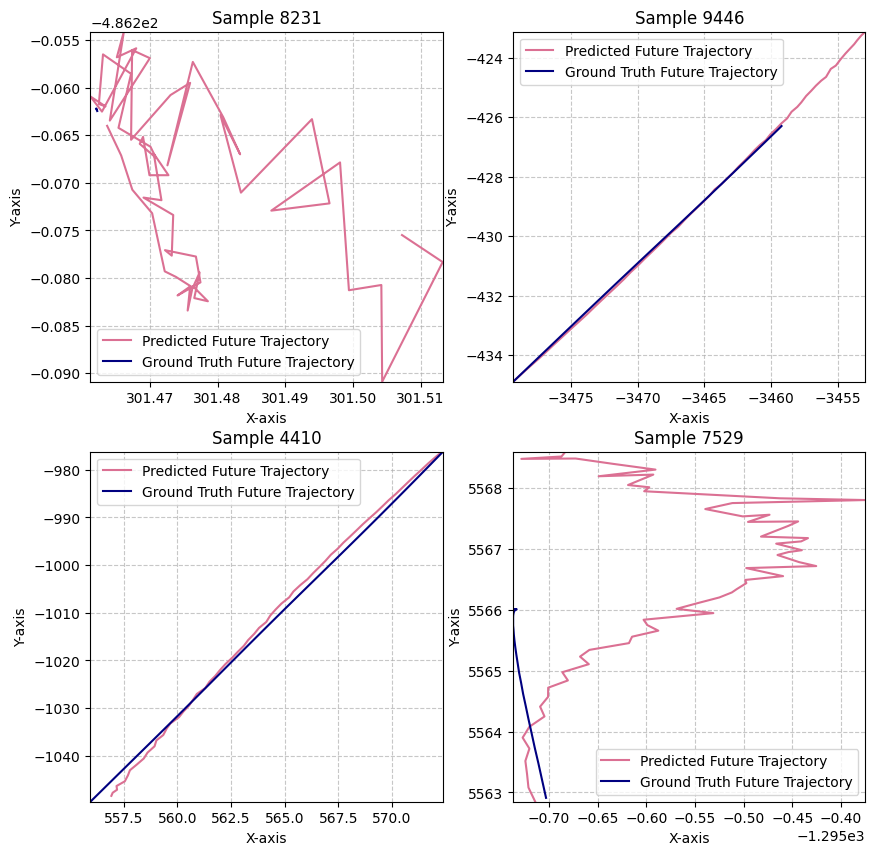

In [16]:
model = get_model()
if not isinstance(model, SceneContextModel):
    # LSTM can handle the timeseries data directly
    # TrajectoryDataset expects numpy arrays
    collate_func = lambda x: Batch.from_data_list(x)
    train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
else:
    train_x: np.ndarray = train_data[..., :50, :]
    train_y: np.ndarray = train_data[:, 0, 50:, :2]
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

visualize_predictions(model, train_dataset)